In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

import os, json
import shutil
from glob import glob
import random
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image 

In [3]:
from importlib import reload
import utils; reload(utils)
from utils import plots

/home/leo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

## Create validation set and sample

In [5]:
NB_ROOT = os.getcwd()

In [6]:
DATA_HOME_DIR = os.path.join(NB_ROOT, "data/state-farm-distracted-driver-detection")
results_path = os.path.join(DATA_HOME_DIR, 'results')

In [7]:
%mkdir -p $DATA_HOME_DIR
%cd $DATA_HOME_DIR
%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/leo/src/fastai-courses/deeplearning1/nbs/data/state-farm-distracted-driver-detection


In [8]:
# !kg download -c state-farm-distracted-driver-detection
!mv test/*.jpg test/unknown

mv: cannot stat `test/*.jpg': No such file or directory


## Inspect the Driver-imgs sheet

In [9]:
driver_imgs = pd.read_csv('driver_imgs_list.csv')

In [10]:
driver_imgs.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [11]:
driver_imgs.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_20846.jpg
freq,1237,2489,1


In [12]:
driver_imgs.groupby('subject').agg('count')

,classname,img
subject,,
p002,725,725
p012,823,823
p014,876,876
p015,875,875
p016,1078,1078
p021,1237,1237
p022,1233,1233
p024,1226,1226
p026,1196,1196


In [13]:
def show_driver_img(subject):
    df = driver_imgs.loc[driver_imgs['subject']==subject].sample(frac=0.01)
    imgs = []
    for idx, row in df.iterrows():
        path = 'train/{}/{}'.format(row['classname'], row['img'])
        imgs.append(mpimg.imread(path))
    plots(imgs, figsize=(24,12))

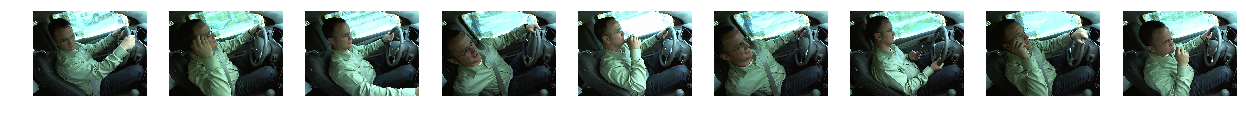

In [14]:
show_driver_img('p051')

In [15]:
# Create valid set img dirs(with lables)
for i in range(10):
    try:
        os.makedirs('valid/c{}/'.format(i))
    except FileExistsError:
        pass

In [16]:
def move_driver_to_validset(subject):
    df = driver_imgs.loc[driver_imgs['subject']==subject]
    for idx, row in df.iterrows():
        train_path = 'train/{}/{}'.format(row['classname'], row['img'])
        valid_dir = 'valid/{}'.format(row['classname'])
        shutil.move(train_path, valid_dir)
        

In [17]:
# move_driver_to_validset('p014')
# move_driver_to_validset('p064')
# move_driver_to_validset('p015')

# Build Model

In [18]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

In [19]:
class Vgg16(object):
    def __init__(self, input_shape=(224, 224, 3),):
        self.input_shape = input_shape
        self.build()
    
    def build(self):
        base_model = applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        for layer in base_model.layers:
            layer.trainable = False
        
        top_model = Sequential()
        top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
        top_model.add(Dense(256, activation='relu'))
        top_model.add(Dense(10, activation='softmax'))
        
        model = Model(
            inputs=base_model.input,
            outputs=top_model(base_model.output)
        )
        model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
            metrics=['accuracy']
        )
        
        self.base_model = base_model
        self.top_model = top_model
        self.model = model

    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs, train_batches, valid_batches):
        for epoch in range(epochs):
            print("Running epoch: %d" % epoch)
            self.model.fit_generator(
                train_batches,
                epochs=1,
                steps_per_epoch=train_batches.samples//BATCH_SIZE,
                validation_data=valid_batches,
                validation_steps=valid_batches.samples//BATCH_SIZE,
            )
            latest_weights_filename = 'ft%d.h5' % epoch
            self.model.save_weights(os.path.join(results_path, latest_weights_filename))
            print("Completed %s fit operations" % epoch)


In [20]:
# !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 --no-check-certificate -P ~/.keras/models


In [21]:
model = Vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Train

In [22]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=16, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        # 224x224 is the image size used by ImageNet
        return gen.flow_from_directory(
            path, target_size=(224,224),
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size
        )

In [23]:
_path = DATA_HOME_DIR
# _path = DATA_HOME_DIR + '/sample' # Only for sample tests!
test_path = os.path.join(DATA_HOME_DIR, 'test')
results_path = os.path.join(DATA_HOME_DIR, 'results')
train_path = os.path.join(_path, 'train')
valid_path = os.path.join(_path, 'valid')
test_path = os.path.join(_path, 'test')

In [24]:
! cd $NB_ROOT
BATCH_SIZE=64

train_batches = get_batches(train_path, batch_size=BATCH_SIZE)
valid_batches = get_batches(valid_path, batch_size=BATCH_SIZE*2)

Found 19853 images belonging to 10 classes.
Found 2571 images belonging to 10 classes.


## Fine tune the last layer

In [ ]:
model.fit(10, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
309/310 [============================>.] - ETA: 21s - loss: 4.7534 - acc: 0.6746

## Training more layers

In [175]:
first_dense_layer_idx = [
    idx for idx, layer in enumerate(model.layers) if type(layer) is Dense
][0]

for layer in layers[first_dense_layer_idx:]:
    layer.trainable=True


In [176]:
fit_model(model)

Running epoch: 0
Epoch 1/1
20187/20187 [==============================] - 5242s - loss: 10.1959 - acc: 0.3549 - val_loss: 9.6843 - val_acc: 0.3925
Completed 5 fit operations
Running epoch: 1
Epoch 1/1
20187/20187 [==============================] - 5232s - loss: 10.2287 - acc: 0.3537 - val_loss: 9.3517 - val_acc: 0.4171
Completed 5 fit operations
Running epoch: 2
Epoch 1/1
20187/20187 [==============================] - 5230s - loss: 10.2638 - acc: 0.3520 - val_loss: 9.6300 - val_acc: 0.3961
Completed 5 fit operations
Running epoch: 3
Epoch 1/1
20187/20187 [==============================] - 5231s - loss: 10.2615 - acc: 0.3537 - val_loss: 9.6404 - val_acc: 0.3943
Completed 5 fit operations
Running epoch: 4
Epoch 1/1
20187/20187 [==============================] - 5232s - loss: 10.2401 - acc: 0.3542 - val_loss: 9.4535 - val_acc: 0.4090
Completed 5 fit operations


In [182]:
test_batches = get_batches(
    test_path, batch_size=BATCH_SIZE * 2, shuffle=False, class_mode=None)

Found 79726 images belonging to 1 classes.


## Predict

In [45]:
def predict(model, test_batches):
    return model.predict_generator(test_batches, test_batches.nb_sample)


In [ ]:
preds = predict(model, test_batches)

In [ ]:
sbm = pd.DataFrame(preds.copy(), columns="c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','))
sbm['img'] = [f.replace('unknown/', '') for f in test_batches.filenames]
for col in "c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','):
    sbm[col] = np.clip(sbm[col], 0.1, 0.9)

sbm = sbm.set_index(['img'])
sbm = sbm.sort_index()

In [ ]:
sbm.to_csv('submission.csv')

In [ ]:
!kg submit -c state-farm-distracted-driver-detection submission.csv

# Predict on the validation data set

In [81]:
val_preds = predict(model, valid_batches)

In [95]:
valid_batches.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [103]:
pred_class = np.argmax(val_preds, axis=1)

In [134]:
correct = np.where(valid_batches.classes == pred_class)[0]

In [136]:
incorrect = np.where(valid_batches.classes != pred_class)[0]

In [150]:
def plot_imgs(idxes, size=5, titles=None):
    idxes = np.random.permutation(idxes)[:size]
    imgs = [
        image.load_img(
            os.path.join(valid_path, valid_batches.filenames[i])
        ) for i in idxes
    ]
    if titles:
        titles = [titles[i] for i in idxes]
    plots(imgs, titles=titles)

In [153]:
indices2labels = {val: key for key, val in valid_batches.class_indices.items()}

In [158]:
val_titles = [
    '{} vs {}'.format(indices2labels[vc], indices2labels[pc])
    for vc, pc in  zip(valid_batches.classes, pred_class)
]

**The 10 classes:**

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger


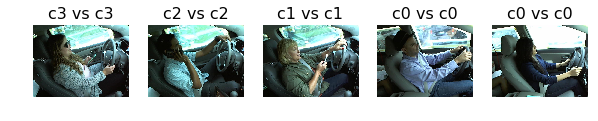

In [163]:
plot_imgs(correct, titles=val_titles)

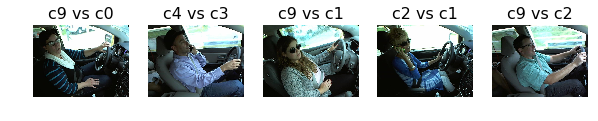

In [167]:
plot_imgs(incorrect, titles=val_titles)